## About Data: 
#### Where the data comes from:
- Country Codes with Continent https://gist.github.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c 
- Minimized Data 1960-2050 https://databank.worldbank.org/reports.aspx?source=Health%20Nutrition%20and%20Population%20Statistics%3A%20Population%20estimates%20and%20projections

Here all countries and times were selected however when considering the series
we removed the % based data of the population for males and females. This is due
to the download limitations of the csv file cells on their website.

## Linear Regression
Steps:
 1. dummy variable encode categorical
 2. run PCA
 3. split data
 4. fit model

## objective of model


In [218]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import pycountry #country codes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale #data scaling
from sklearn import decomposition #PCA
from sklearn import linear_model #linear model

In [115]:
# load data
def loadData():
    pop_data = pd.read_csv('../Datasets/Population Data 1960-2050.csv', low_memory=False)
    pop_data = pop_data.replace('..', np.nan)
    pop_data = pop_data.iloc[: , 1:] 
    return pop_data

In [116]:
# missing data check
def checkForMissingData(pop_data):
    plt.figure()
    sns.heatmap(pop_data.isnull().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})
    plt.title("Missing data across dataset")
    plt.show()

In [117]:
# add country code
#list of country codes
def getCountryNonCountryData(pop_data):
    country_codes = []
    country_names = []
    for country in pycountry.countries:
        country_codes.append(country.alpha_3)
        country_names.append(country.name)
    country_codes.sort(key=str.lower)
    country_names.sort(key=str.lower)

    country_data = pop_data[pop_data.Country_Code.isin(country_codes)]
    non_country_data = pop_data[~pop_data.Country_Code.isin(country_codes)]
    non_country_data = non_country_data.iloc[: , 3:] # Removing Continent Codes for non-Nations (Will be NA anyway)
    return country_data, non_country_data

In [118]:
def getTotalPopulation(country_data):
    pop_total = country_data[country_data.Series_Code == "SP.POP.TOTL"] #Population Totals
    return pop_total

In [134]:
#remove unwanted columns
def formatTotalPopulation(pop_total):
    pop_total = pop_total.drop(['Continent_Code','Country_Number','Country_Name','Series_Name','Series_Code'], axis=1)
    pop_total =  pop_total.drop(pop_total.columns[63:],axis=1)
    years = pop_total.columns[2:]
    pop_total[years] = pop_total[years].apply(pd.to_numeric)

    #fix column names - years
    pop_total.columns = pop_total.columns.str.strip("[]")
    return pop_total

In [135]:
# outliers check
# def checkForOutliersInData(pop_total):
#     sns.boxplot(y=pop_total["Continent_Name"], x=pop_total["1960"])
    

In [136]:
def addCategoricalDummies(pop_total):
    # create dummies for categorical data
    pop_total = pd.get_dummies(pop_total, columns=['Country_Code'])
    return pop_total

In [137]:
# visualize data

In [138]:
# other check on data if required

In [139]:
# PCA
def performPCA(pop_total):
    #scale data
    X = scale(pop_total)
    pca = decomposition.PCA(n_components=3)
    pca.fit(X)
    #pca scores
    pca_scores = pca.transform(X)
    return pca, pca_scores
    

In [280]:
def continetWiseDataSplit(pop_total):
    continents = set(pop_total["Continent_Name"])
    continent_pop = {}
    for continent in continents:
        continent_df = pop_total[pop_total['Continent_Name'] == continent]
        continent_df = continent_df.drop(['Continent_Name','Country_Code'], axis=1)
        continent_df = continent_df.T
        continent_df.index = continent_df.index.rename('year')
        continent_df.reset_index(inplace=True)
        continent_df[continent+'_sum'] =  continent_df[2:].sum(axis=1)#total population of continent
        continent_pop[continent] = continent_df[['year',continent+'_sum']]
        continent_pop[continent].plot(title = continent+" Population Trends")
        plt.ylabel(continent + "Population")
        plt.xlabel("Census Years")
        plt.legend(["Continent"])
#         img_name = './Images/'+ continent + '_population.jpg'
#         plt.savefig(img_name, bbox_inches='tight')
    return continent_pop

In [269]:
# split data
def splitData(continent_pop):
    continent_train = {}
    continent_test = {}
    for continent in continent_pop.keys():
        train, test = train_test_split(continent_pop[continent], test_size=0.2)
        continent_train[continent] = train
        continent_test[continent] = test
    return continent_train,continent_test

In [270]:
# fit model
def fitLinearRegression(continent_train):
    continent_models = {}
    for continent in continent_train.keys():
        continent_train[continent] = continent_train[continent].dropna()
        x = continent_train[continent]['year'].values
        y = continent_train[continent][continent+'_sum'].values
        x = x.reshape(-1, 1)
        model = linear_model.LinearRegression().fit(x, y)
        linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
        continent_models[continent] = [model, x, y]
    return continent_models



In [271]:
#model scores
def linearRegressionScores(continent_models):
    for continent in continent_models.keys():
        x = continent_models[continent][1]
        y = continent_models[continent][2]
        print(continent + "----------------------------------------------------------------------")
        print("Linear Regression Score: ",continent_models[continent][0].score(x,y))
        print("Coefficent: ", continent_models[continent][0].coef_)
        print("Intercept: ", continent_models[continent][0].intercept_)

In [272]:
# test
def testModel(continent_test, continent_models):
    for continent in continent_test.keys():
        continent_test[continent] = continent_test[continent].dropna()
        
        x_test = continent_test[continent]['year'].values
        x_test = x_test.reshape(-1, 1)
        y_test = continent_test[continent][continent+'_sum'].values
        
        y_pred = continent_models[continent][0].predict(x_test)
        df = pd.DataFrame({'actual': y_test, 'predicted': y_pred })
        
        r_squared = sk.metrics.r2_score(y_test,y_pred)
        mae = sk.metrics.mean_absolute_error(y_test,y_pred)
        rmse = sk.metrics.mean_squared_error(y_test,y_pred)
        print(continent + "----------------------------------------------------------------------")
        print("R Squared: ",r_squared)
        print("Mean Absolute Error: ", mae)
        print("Root Mean Squared Error: ", rmse)

In [273]:
# validation
def validateModel(continent_models):
    print("Validate Model")

In [274]:
# predict
def predictPopulationEstimation(continent_models):
    print("Predict Values")
#     for continent in continent_test.keys():
        

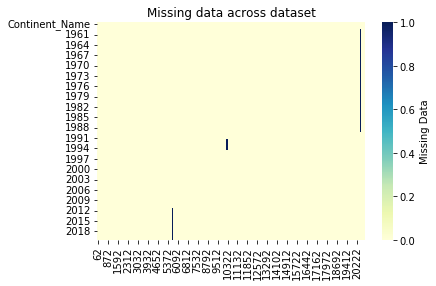

South America----------------------------------------------------------------------
Linear Regression Score:  0.9983564441308472
Coefficent:  [4946690.17082346]
Intercept:  -9551247124.412601
Africa----------------------------------------------------------------------
Linear Regression Score:  0.9680280808174375
Coefficent:  [17481073.22425074]
Intercept:  -34103754671.33312
North America----------------------------------------------------------------------
Linear Regression Score:  0.9989937477011296
Coefficent:  [5459239.01846979]
Intercept:  -10435252478.947948
Oceania----------------------------------------------------------------------
Linear Regression Score:  0.9901521054633409
Coefficent:  [437727.72879493]
Intercept:  -843082826.1324081
Asia----------------------------------------------------------------------
Linear Regression Score:  0.9985959401580781
Coefficent:  [50567104.13647813]
Intercept:  -97351058775.99104
Europe------------------------------------------------------

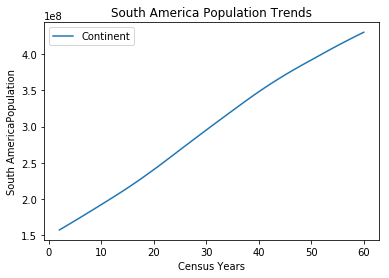

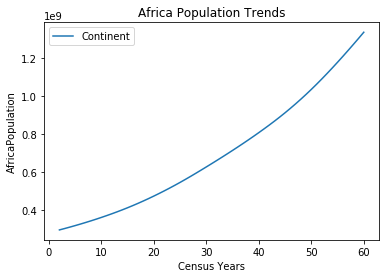

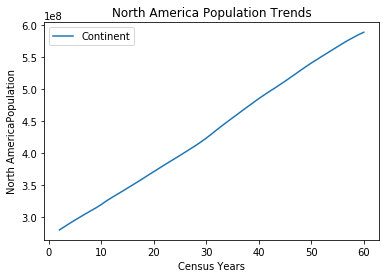

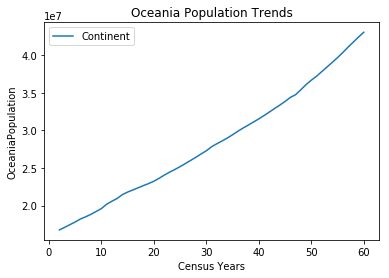

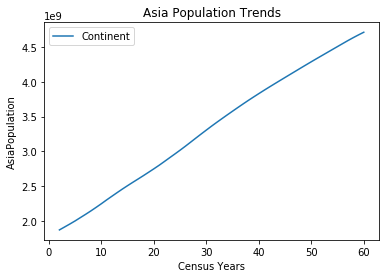

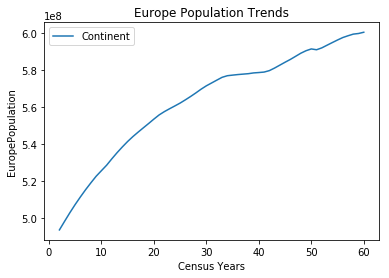

In [281]:
# main function
def main():
    pop_data = loadData()
   
    #checkForMissingData(pop_data)
    #get country and non coutry data
    country_data, non_country_data = getCountryNonCountryData(pop_data)
    
    # get total population of all countries
    pop_total = getTotalPopulation(country_data)
    
    # remove unwanted columns and format column names
    pop_total = formatTotalPopulation(pop_total)
    
    #check for missing data
    checkForMissingData(pop_total)
    
    #drop missing values
    pop_total = pop_total.dropna()
    
    #get total population of each continent
    continent_pop = continetWiseDataSplit(pop_total)
    
    #prepare data
    continent_train, continent_test =  splitData(continent_pop)
    
    # fit model for each continent
    continent_models  = fitLinearRegression(continent_train)
    
    #print scores, 
    linearRegressionScores(continent_models)
    
    #testmodel
    testModel(continent_test,continent_models)

if __name__ == "__main__":
    main()

In [170]:
# conclusion